# Term2 Sprint18 授業課題 
## コーディング課題：公開されている実装を動かす

Sprint16で読んだFaster R-CNN[1]の実装を動かす。

[1]Ren, S., He, K., Girshick, R., Sun, J.: Faster r-cnn: Towards real-time object detection with region proposal networks. In: Advances in neural information processing systems. (2015) 91–99

https://arxiv.org/pdf/1506.01497.pdf

以下のものを使用する(Kerasを使用した実装)。

[duckrabbits/ObjectDetection at master](https://github.com/duckrabbits/ObjectDetection/tree/master "duckrabbits/ObjectDetection at master")

## 1. 学習と推定
READMEを参考に上記実装を動かす。

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/ObjectDetection")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
os.getcwd()

'/content/gdrive/My Drive/Colab Notebooks/ObjectDetection'

In [3]:
!ls

annotation.txt		out.csv     save			     train.py
kaggle_simpson_testset	predict.py  simpsons_dataset
model			README.md   the-simpsons-characters-dataset


In [4]:
!python3 train.py -p annotation.txt

Using TensorFlow backend.
Parsing annotation files
Training images per class (19 classes) :
{'abraham_grampa_simpson': 687,
 'apu_nahasapeemapetilon': 206,
 'bart_simpson': 650,
 'bg': 0,
 'charles_montgomery_burns': 650,
 'chief_wiggum': 209,
 'comic_book_guy': 208,
 'edna_krabappel': 212,
 'homer_simpson': 718,
 'kent_brockman': 213,
 'krusty_the_clown': 429,
 'lisa_simpson': 756,
 'marge_simpson': 629,
 'milhouse_van_houten': 210,
 'moe_szyslak': 403,
 'ned_flanders': 675,
 'nelson_muntz': 219,
 'principal_skinner': 614,
 'sideshow_bob': 201}
-------------------------------
path to config file : ./save/train_20190610-162020_config.pickle
-------------------------------
Instructions for updating:
Colocations handled automatically by placer.
Epoch 1/100
2019-06-10 17:46:31.309211: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2200000000 Hz
2019-06-10 17:46:31.309540: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x2b6ffa0 executing computatio

In [12]:
!python3 predict.py -i ./kaggle_simpson_testset_10 -c ./save/train_20190610-162020_config.pickle

Using TensorFlow backend.
Instructions for updating:
Colocations handled automatically by placer.
2019-06-11 01:51:58.307175: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-06-11 01:51:58.307551: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x87c54a0 executing computations on platform Host. Devices:
2019-06-11 01:51:58.307606: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-06-11 01:51:58.549681: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-06-11 01:51:58.550272: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x87c5760 executing computations on platform CUDA. Devices:
2019-06-11 01:51:58.550304: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): Tesla T4, Compute Capability

## 2. 論文と実装の対応
コードリーディングを行う。

まず、Faster R-CNN[1]において重要だと考えた部分を列挙する。そして、それに対応するコードを見つける。

（例）

- RPNを実現しているコードはどこか
- RoIプーリングを実現しているコードはどこか

フレームワークには畳み込み層など一般的なものはクラスが用意されているが、RoIプーリングなど特定の手法限定のものは用意されていない。  
オリジナルのレイヤーを作成することが可能であり、Kerasであれば以下のページに情報がまとまっている。

[オリジナルのKerasレイヤーを作成する - Keras Documentation](https://keras.io/ja/layers/writing-your-own-keras-layers/ "オリジナルのKerasレイヤーを作成する - Keras Documentation")

**参考**

KerasではVGG16のクラスが用意されているため、簡単に利用ができる。  
include_top=Falseの引数を与えることで、出力のための全結合層部分が除かれる。  
weights='imagenet'でImageNetを利用した学習済みモデルも手に入り、転移学習が行える。  
weights='None'とすればランダムな初期化となる。

[Applications - Keras Documentation](https://keras.io/ja/applications/#vgg16 "Applications - Keras Documentation")

## train.pyの該当コード

In [0]:
# CNNを実現しているコード
loss_rpn = model_rpn.train_on_batch(X, Y)

# RPNを実現しているコード
P_rpn = model_rpn.predict_on_batch(X)

# RoIプーリングを実現しているコード
R = roi_helpers.rpn_to_roi(P_rpn[0], P_rpn[1], C, K.image_dim_ordering(), use_regr=True, overlap_thresh=0.7, max_boxes=300)


## faster_rcnn.pyの該当コード

In [0]:
from keras import backend as K
from keras.optimizers import Adam
from keras.layers import Input
from keras.models import Model

from model import losses as losses
from model import resnet as nn

def get_model(C, classes_count):
    img_input = Input(shape=(None, None, 3))
    roi_input = Input(shape=(C.num_rois, 4))

    # CNNを実現しているコード(rensetのnn_baseメソッドを利用)
    shared_layers = nn.nn_base(img_input, trainable=True)

    # RPNを実現しているコード(resnetのrpnメソッドを利用)
    num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)
    rpn = nn.rpn(shared_layers, num_anchors)

    # 分類器を実現しているコード(resnetのclassifierメソッドを利用)
    classifier = nn.classifier(shared_layers, roi_input, C.num_rois, nb_classes=len(classes_count), trainable=True)

    # モデルをコンパイル
    model_rpn = Model(img_input, rpn[:2])
    model_classifier = Model([img_input, roi_input], classifier)
    model_all = Model([img_input, roi_input], rpn[:2] + classifier)

    model_rpn.compile(optimizer=Adam(lr=1e-4), loss=[losses.rpn_loss_cls(num_anchors), losses.rpn_loss_regr(num_anchors)])
    model_classifier.compile(optimizer=Adam(lr=1e-4), loss=[losses.class_loss_cls, losses.class_loss_regr(len(classes_count)-1)], metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'})
    model_all.compile(optimizer='sgd', loss='mae')

    return model_rpn, model_classifier, model_all

## model.pyの該当コード

In [0]:
from __future__ import print_function
from __future__ import absolute_import

from keras.layers import Input, Add, Dense, Activation, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, \
    AveragePooling2D, TimeDistributed

from keras import backend as K

from model.RoiPoolingConv import RoiPoolingConv
from model.FixedBatchNormalization import FixedBatchNormalization


def nn_base(input_tensor=None, trainable=False):

    # Determine proper input shape
    if K.image_dim_ordering() == 'th':
        input_shape = (3, None, None)
    else:
        input_shape = (None, None, 3)

    if input_tensor is None:
        img_input = Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor

    if K.image_dim_ordering() == 'tf':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((3, 3))(img_input)

    x = Convolution2D(64, (7, 7), strides=(2, 2), name='conv1', trainable = trainable)(x)
    # エラー
    x = FixedBatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    # エラー
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1), trainable = trainable)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b', trainable = trainable)
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c', trainable = trainable)

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a', trainable = trainable)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b', trainable = trainable)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c', trainable = trainable)
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d', trainable = trainable)

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a', trainable = trainable)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b', trainable = trainable)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c', trainable = trainable)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d', trainable = trainable)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e', trainable = trainable)
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f', trainable = trainable)

    return x


def rpn(base_layers,num_anchors):

    x = Convolution2D(512, (3, 3), padding='same', activation='relu', kernel_initializer='normal', name='rpn_conv1')(base_layers)

    x_class = Convolution2D(num_anchors, (1, 1), activation='sigmoid', kernel_initializer='uniform', name='rpn_out_class')(x)
    x_regr = Convolution2D(num_anchors * 4, (1, 1), activation='linear', kernel_initializer='zero', name='rpn_out_regress')(x)

    return [x_class, x_regr, base_layers]


def classifier(base_layers, input_rois, num_rois, nb_classes = 21, trainable=False):

    pooling_regions = 14
    input_shape = (num_rois,14,14,1024)
    out_roi_pool = RoiPoolingConv(pooling_regions, num_rois)([base_layers, input_rois])
    out = classifier_layers(out_roi_pool, input_shape=input_shape, trainable=True)

    out = TimeDistributed(Flatten())(out)

    out_class = TimeDistributed(Dense(nb_classes, activation='softmax', kernel_initializer='zero'), name='dense_class_{}'.format(nb_classes))(out)
    # note: no regression target for bg class
    out_regr = TimeDistributed(Dense(4 * (nb_classes-1), activation='linear', kernel_initializer='zero'), name='dense_regress_{}'.format(nb_classes))(out)
    return [out_class, out_regr]


## 3. 学習済みの重みによる推定

シンプソンズのデータセットをFaster R-CNN以外の手法で学習・推定を行う。YOLOv3[2]のKeras実装を使う。

[qqwweee/keras-yolo3: A Keras implementation of YOLOv3 (Tensorflow backend)](https://github.com/qqwweee/keras-yolo3 "qqwweee/keras-yolo3: A Keras implementation of YOLOv3 (Tensorflow backend)")

[2]Jeseph Redmon, Ali Farhadi. YOLOv3: An Incremental Improvement

https://pjreddie.com/media/files/papers/YOLOv3.pdf

**Sprint18で使用した実装（再掲）**

[lasershow/SimpsonRecognition: Detect and recognize The Simpsons characters using Keras and Faster R-CNN](https://github.com/lasershow/SimpsonRecognition "lasershow/SimpsonRecognition: Detect and recognize The Simpsons characters using Keras and Faster R-CNN")

学習済みの重みを使い推定を行う方法がREADME.mdのQuick Startに記載されている。

まずはこの通りにして各自何かしらの画像や動画に対して検出を行う。

出力結果を課題の一部として提出する。

## Installing The Base System

In [3]:
# darknetを保存
!git clone https://github.com/pjreddie/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 5901, done.
remote: Total 5901 (delta 0), reused 0 (delta 0), pack-reused 5901
Receiving objects: 100% (5901/5901), 6.16 MiB | 8.29 MiB/s, done.
Resolving deltas: 100% (3922/3922), done.
Checking out files: 100% (979/979), done.


In [4]:
cd darknet

/content/gdrive/My Drive/Colab Notebooks/ObjectDetection/darknet


In [7]:
!make

mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/gemm.c -o obj/gemm.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/utils.c -o obj/utils.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/cuda.c -o obj/cuda.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/deconvolutional_layer.c -o obj/deconvolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/convolutional_layer.c -o obj/convolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/list.c -o obj/list.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/image.c -o obj/image.o
gcc 

## Detection Using A Pre-Trained Model

In [8]:
# dog.jpgで物体検出
!./darknet detect cfg/yolov3.cfg yolov3.weights data/dog.jpg

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

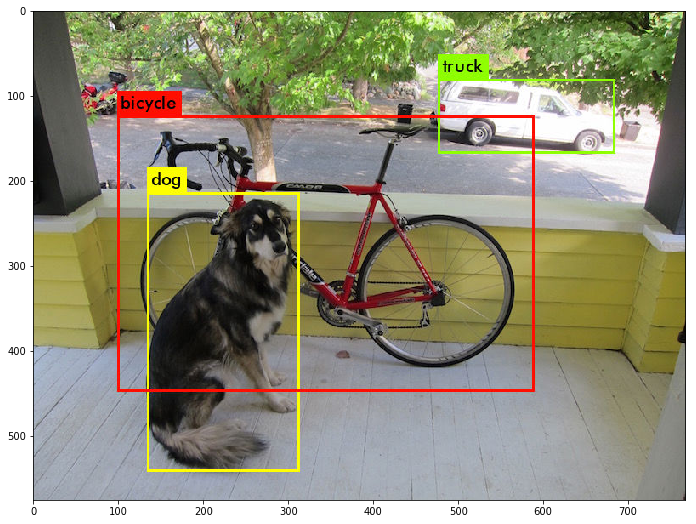

In [15]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 画像の読み込み
im = Image.open("./predictions.jpg")

# 画像をarrayに変換
im_list = np.asarray(im)

# 表示
plt.figure(figsize=(20,9))
plt.imshow(im_list)
plt.show()

In [16]:
# person.jpgでも物体検出してみる
!./darknet detect cfg/yolov3.cfg yolov3.weights data/person.jpg

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

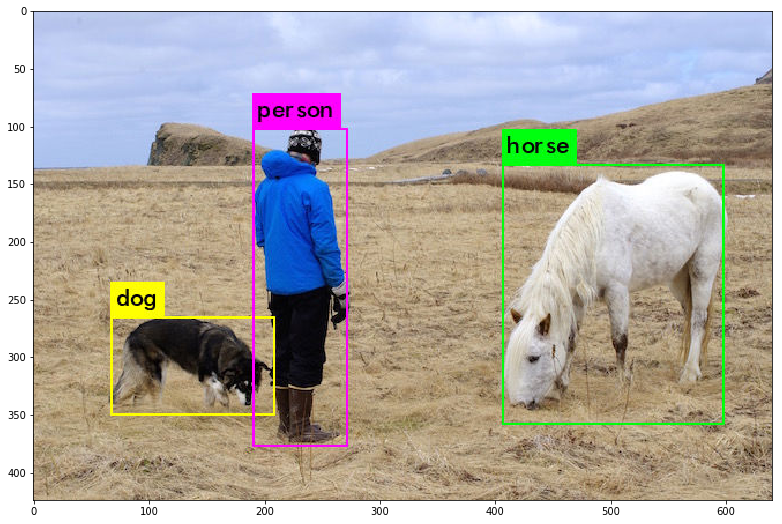

In [17]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 画像の読み込み
im = Image.open("./predictions.jpg")

# 画像をarrayに変換
im_list = np.asarray(im)

# 表示
plt.figure(figsize=(20,9))
plt.imshow(im_list)
plt.show()

In [19]:
# 画像を指定しない場合は、インラインボックスで様々な画像を続けて指定できる。
!./darknet detect cfg/yolov3.cfg yolov3.weights

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

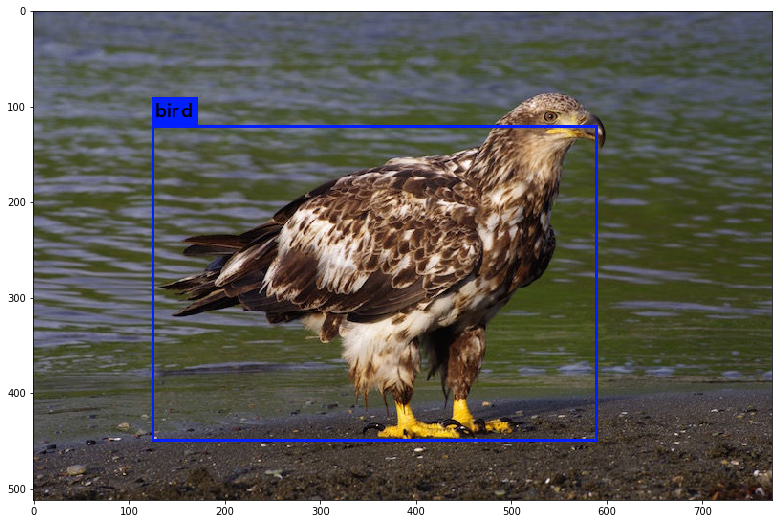

In [20]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# 画像の読み込み
im = Image.open("./predictions.jpg")

# 画像をarrayに変換
im_list = np.asarray(im)

# 表示
plt.figure(figsize=(20,9))
plt.imshow(im_list)
plt.show()

## 4. 学習のためのファイルを作成
新しいデータ（シンプソンズデータセット）を学習する。  
README.mdのTrainingを読み、シンプソンズデータセットを学習するために必要なファイルを作成する。

アノテーションファイルの形式がSprint18で扱った実装のものとは異なっているので、変換する必要がある。

In [0]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# annotation.txtを変換
df = pd.read_csv("annotation.txt", header=None)

le = LabelEncoder()
df[5] = le.fit_transform(df[5])

train = np.array(df.iloc[:, :2])

train_list = []

for row in train:
    a = " ".join([str(n) for n in row])
    train_list.append(a)

df.iloc[:, 1] = np.array(train_list)

df = df.iloc[:, 1:]

df.to_csv("train.txt", sep=",", header=False, index=False)

## 5. 学習
問題2で作成したファイルを使用して学習する。  
実行環境で学習に時間がかかる場合は、学習が行えることを確認するのみで終えて構わない。

In [5]:
import os
os.getcwd()

'/content/gdrive/My Drive/Colab Notebooks/ObjectDetection'

In [0]:
os.chdir("./keras-yolo3-master")

In [18]:
!python3 convert.py -w yolov3.cfg yolov3.weights model_data/yolo_weights.h5

Using TensorFlow backend.
Loading weights.
Weights Header:  0 2 0 [32013312]
Parsing Darknet config.
Creating Keras model.
Parsing section net_0
Parsing section convolutional_0
conv2d bn leaky (3, 3, 3, 32)
Instructions for updating:
Colocations handled automatically by placer.
2019-06-11 11:53:45.480510: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-06-11 11:53:45.480704: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x2ef5340 executing computations on platform Host. Devices:
2019-06-11 11:53:45.480732: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-06-11 11:53:45.790396: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-06-11 11:53:45.791418: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x2ef4f20 exec

In [5]:
!python3 train.py

Using TensorFlow backend.
Instructions for updating:
Colocations handled automatically by placer.
2019-06-11 17:50:03.576410: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-06-11 17:50:03.576779: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x2ea3340 executing computations on platform Host. Devices:
2019-06-11 17:50:03.576822: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-06-11 17:50:03.820211: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-06-11 17:50:03.820768: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x2ea2f20 executing computations on platform CUDA. Devices:
2019-06-11 17:50:03.820807: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): Tesla T4, Compute Capability